<a href="https://colab.research.google.com/github/5213478/123/blob/main/%E2%80%9Cdouble_CGDNN_3%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.8/dist-packages/h5py/*
Proceed (Y/n)? y
  Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 41.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")
root_path = "/content/gdrive/My Drive/"

Mounted at /content/gdrive/


In [ ]:
#%reset
#%tensorflow_version 1.x
import joblib
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import keras
import math
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Conv2D, Input, Concatenate, Add, ReLU, GRU
from keras.layers.convolutional import Convolution1D ,Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.initializers import glorot_uniform, Constant
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from scipy.interpolate import UnivariateSpline
from keras.utils import to_categorical
from sklearn import preprocessing
from keras.optimizers import Adam
from keras import regularizers


plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
EPOCHS = 100
NUM_CLASSES = 8
BATCH_SIZE = 1024 #time-series
PATIENCE = 10

In [ ]:
#Normalisation is very important
def iq2ampphase(inphase, quad):
    amplitude = np.sqrt(np.square(inphase) + np.square(quad))
    amp_norm = np.linalg.norm(amplitude) #L2 norm
    amplitude = amplitude/amp_norm #normalise
    phase = np.arctan(np.divide(quad, inphase))
    phase = 2.*(phase - np.min(phase))/np.ptp(phase)-1 #rescale phase to range [-1, 1]
    return amplitude, phase

#convert array of multiple iq samples into array of multiple ampphase samples
#ip--ap
def arr_iq2ap(X):
  X_ap = []
  for k in range(X.shape[0]):
    I = X[k][0,:]
    Q = X[k][1,:]
    amp, phase = iq2ampphase(I, Q)
    ap = np.array([amp, phase])#建立数组
    X_ap.append(ap)
  X_ap = np.array(X_ap)
  return X_ap

In [ ]:
#设置混淆矩阵
def generate_confusion_matrix(model, X,y, one_hot_transformer, batch_size):
    """
      y is the one hot encoded label vector passed to the model.evaluate
    """
    #调制--索引
    mod_to_idx = {mod:idx for idx,mod in enumerate(one_hot_transformer.classes_)} # use this to map modulation name to index
    y_hat = model.predict(X, batch_size) #输入测试数据X,输出预测结果y_hat
    y_hat_onehot = np.zeros_like(y_hat) #其维度与矩阵y_hat一致，并为其初始化为全0
    y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
    y_hat_mod = one_hot_transformer.inverse_transform(y_hat_onehot) # transform predictions to strings
    y_mod = one_hot_transformer.inverse_transform(y) # transform ground truth back to strings
    confusion_mat = np.zeros([NUM_CLASSES,NUM_CLASSES])

    acc = np.mean(y_mod == y_hat_mod)
    # fill in the confusion matrix
    for i in range(y.shape[0]):
        
        true_idx = mod_to_idx[y_mod[i]]
        pred_idx = mod_to_idx[y_hat_mod[i]]          
        confusion_mat[pred_idx,true_idx] += 1

    # normalize the matrix column wise
    for i in range(NUM_CLASSES):
        if np.sum(confusion_mat[:,i]) > 0:
          confusion_mat[:,i] /= np.sum(confusion_mat[:,i])
    
    return confusion_mat,acc

 
import seaborn as sns
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges, labels=[]):
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
  
  plt.title(title)
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels, rotation=45)
  plt.tight_layout()
  plt.ylabel('Predicted label')
  plt.xlabel('True label')

In [ ]:
#created my own LabelBinarizer class so can encode both 2-class and multiclass cases
#建立分类函数
class MyLabelBinarizer(preprocessing.LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y

    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
class ModelEvaluater:
  def __init__(self, model, X_train, y_train, X_val, y_val, X_test, y_test,
               labels_test, batch_size, model_name, channels_first=True, feature_type=1):
    # 如果通道在前，输入的类型不变
    if channels_first:
      self.X_train = X_train
      self.X_val = X_val
      self.X_test = X_test
    else:
      self.X_train = X_train.reshape([X_train.shape[0], X_train.shape[2], X_train.shape[1]])
      self.X_val = X_val.reshape([X_val.shape[0], X_val.shape[2], X_val.shape[1]])
      self.X_test = X_test.reshape([X_test.shape[0], X_test.shape[2], X_test.shape[1]])
    
    self.feature_type = feature_type
      
    self.model = model
    self.y_train = y_train
    self.y_val = y_val
    self.y_test = y_test
    self.labels_test = labels_test
    self.model_name = model_name
    self._checkpoint_callback = ModelCheckpoint(filepath=root_path + 'double CGDNN 33/%s-weights-{epoch}.hdf5' % self.model_name,
                                                verbose=1, save_best_only=True)
    self._train_accs = []
    self._val_accs = []
    self._snr_accs = []
    
    self.batch_size = batch_size
    
    # get the modulation types into an array
    self.mod_types = np.unique(labels_test[:,0])
  
    # fit a label binarizer 
    self.mod_to_onehot = MyLabelBinarizer()
    self.mod_to_onehot.fit(self.mod_types)

    # transform the y values to one-hot encoding
    self.y_train = self.mod_to_onehot.transform(y_train)
    self.y_val = self.mod_to_onehot.transform(y_val)
    self.y_test = self.mod_to_onehot.transform(y_test)
  
    print('y_train %s' %(y_train.shape))
    print('y_val %s' %(y_val.shape))
    print('y_test %s' %(y_test.shape))
    

    
  def fit(self, epochs, patience=10):
    curr_X, curr_y = self.X_train, self.y_train
    val_X, val_y = self.X_val, self.y_val
    callbacks = [self._checkpoint_callback, EarlyStopping(patience=patience)]
   
     # train the model
    model_info = self.model.fit(curr_X, curr_y,
                                batch_size=self.batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(val_X, val_y),
                                callbacks=callbacks)

    self._train_accs.extend(model_info.history['accuracy'])
    self._val_accs.extend(model_info.history['val_accuracy'])



  def print_summary(self):
    # plot validation accuracy vs training accuracy
    plt.plot(np.arange(len(self._train_accs)), self._train_accs, '-o', label='training accuracy')
    plt.plot(np.arange(len(self._val_accs)), self._val_accs, '-o', label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.title('%s -validation vs training accuracy' %(self.model_name))
    display(plt.show())

    #plot confusion matrix for all, low, med and high SNR
    # 有出处
    snr_ranges = [(-20, 20), (-10, 5), (6, 20)]
    for snr_rng in snr_ranges:
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_, 
                            title='%s- Confusion Matrix (SNR in range %s) - acc=%s' %(self.model_name, snr_rng, acc*100))
      plt.show()

    # get accuracy per snr
    snr_accs = {}
    # unique函数去除其中重复的元素，并按元素由大到小返回一个新的无元素重复的元组或者列表
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]

      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    # plot the accuracy against the snr
    plt.plot(list(snr_accs.keys()),list(snr_accs.values()))
    plt.xlabel("SNR (dB)")
    plt.ylabel("Classification Accuracy")
    plt.xticks(list(snr_accs.keys()))
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.grid(True)
    plt.show()

    # acc--snr曲线图函数
  def accpersnr_model(self):
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    return snr_accs

    # 
  def confmat_snr(self, snr_rng):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_, 
                            title='%s- Confusion Matrix (SNR in range %s) - acc=%s' %(self.model_name, snr_rng, acc*100))
      plt.show()

In [ ]:
import joblib
data = joblib.load(root_path + 'double CGDNN 33/data/rml_trainvaltest3.hdf5')

In [ ]:
#quick understanding of data
print(data.keys())
print('Train val test size: ', data['train']['X'].shape, data['val']['X'].shape, data['test']['X'].shape)
print('Check if data is shuffled: ', data['val']['labels'][:10])

uniq, counts = np.unique(data['train']['labels'][:,1], return_counts = True)
print('Check snr range: ', uniq)
print('Check distribution of samples across SNR: ', counts)

uniq, counts = np.unique(data['train']['labels'][:,0], return_counts = True)
print('Check modulation types: ', uniq)
print('Check distribution of samples across modulation types: ', counts)

dict_keys(['train', 'val', 'test'])
Train val test size:  (147400, 2, 128) (28600, 2, 128) (44000, 2, 128)
Check if data is shuffled:  [['QAM64' '12']
 ['QAM64' '-20']
 ['QAM64' '-20']
 ['CPFSK' '12']
 ['WBFM' '18']
 ['AM-DSB' '-20']
 ['PAM4' '-12']
 ['QAM64' '-4']
 ['PAM4' '12']
 ['QAM64' '10']]
Check snr range:  ['-10' '-12' '-14' '-16' '-18' '-2' '-20' '-4' '-6' '-8' '0' '10' '12'
 '14' '16' '18' '2' '4' '6' '8']
Check distribution of samples across SNR:  [7327 7467 7344 7417 7402 7428 7457 7344 7335 7355 7362 7329 7315 7407
 7362 7366 7483 7278 7306 7316]
Check modulation types:  ['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']
Check distribution of samples across modulation types:  [13447 13432 13547 13458 13375 13356 13336 13320 13329 13403 13397]


In [ ]:
#load data
X_train = data['train']['X']
labels_train = data['train']['labels'] 
y_train = labels_train[:,0]

X_val = data['val']['X']
labels_val = data['val']['labels'] 
y_val = labels_val[:,0]

X_test = data['test']['X']
labels_test = data['test']['labels'] 
y_test = labels_test[:,0]

In [ ]:
#convert to ampphase
X_ap_train = arr_iq2ap(X_train)
X_ap_val = arr_iq2ap(X_val)
X_ap_test = arr_iq2ap(X_test)

In [ ]:
def eca(inputs, b=1, gama=2):
 
 # 输入特征图的通道数
 in_channel = inputs.shape[-1]
 
 # 根据公式计算自适应卷积核大小
 kernel_size = int(abs((math.log(in_channel, 2) + b) / gama))
 
 # 如果卷积核大小是偶数，就使用它
 if kernel_size % 2:
  kernel_size = kernel_size
 
 # 如果卷积核大小是奇数就变成偶数
 else:
  kernel_size = kernel_size + 1
 
 # [h,w,c]==>[None,c] 全局平均池化
 x = keras.layers.GlobalAveragePooling2D()(inputs)
 
 # [None,c]==>[c,1]
 x = keras.layers.Reshape(target_shape=(in_channel, 1))(x)
 
 # [c,1]==>[c,1]
 x = keras.layers.Conv1D(filters=1, kernel_size=kernel_size, padding='same', use_bias=False)(x)
 
 # sigmoid激活
 x = keras.layers.Activation('sigmoid')(x)
 
 # [c,1]==>[1,1,c]
 x = keras.layers.Reshape((1,1,in_channel))(x)
 
 # 结果和输入相乘
 outputs = keras.layers.multiply([inputs, x])
 
 return outputs

In [ ]:
def senet(x):
  in_channel = x.shape[-1]
  x00 = keras.layers.GlobalAveragePooling2D()(x)
  # 全局平均池化[h,w,c]==>[None,c]
  #input_plane = Input(shape=(CHANNELS+num, CHANNELS+num, 1)) 
  #input_1 = input_plane[:,:CHANNELS, :CHANNELS,:]
  #input_1= Input(shape=(CHANNELS, CHANNELS, 1)) #采用Input层来构建input_1

  x0 = x00[:, None, None, :]
  # [None,c]==>[1,1,c]
  #x = keras.layers.Reshape(target_shape=(1,1,in_channel))(x)
  #x = Input(shape=(1, 1, in_channel))
 # [1,1,c]==>[1,1,c/4]
 # x1 = keras.layers.Conv2D(filters=in_channel//4, kernel_size=1, strides=1)(x0)  # 全连接下降通道数
  x1 = keras.layers.Dense(in_channel//2)(x0)
 # relu激活
  x2 = keras.layers.Activation('relu')(x1)
 
 # [1,1,c/4]==>[1,1,c]
  x3 = keras.layers.Dense(in_channel)(x2)  # 全连接上升通道数
 
 # sigmoid激活，权重归一化
  x4 = keras.layers.Activation('sigmoid')(x3)
 
 # [h,w,c]*[1,1,c]==>[h,w,c]
  new_x = keras.layers.multiply([x, x4])  # 归一化权重和原输入特征图逐通道相乘
  return new_x

In [ ]:
def build_cgdnn_net1(X1, X2):
  dr = 0.5  # dropout rate l

  # Reshape [N,2,128] to [N,1,2,128] on input
  x = Input(shape=(1, X1, X2))

  # channels_first corresponds to inputs with shape (batch, channels, height, width).
  # Build our model
  # 1*8--1*8--1*8
  #input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(x)

  layer1 = Convolution2D(50, (1, 8), padding='valid', activation="relu", name="conv101", kernel_initializer='glorot_uniform', data_format="channels_first")(x)
  layer1 = Dropout(dr)(layer1)
  layer1 = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)

  #layer10 = Convolution2D(50, (1, 8), padding="valid", activation="relu", name="conv1011", kernel_initializer='glorot_uniform', data_format="channels_first")(layer1)
  #layer10 = Dropout(dr)(layer10)

  layer2 = Convolution2D(50, (1, 8), padding="valid", activation="relu", name="conv201", kernel_initializer='glorot_uniform', data_format="channels_first")(layer1)
  layer2 = Dropout(dr)(layer2)
  layer2 = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

  #layer20 = Convolution2D(50, (1, 8), padding='valid', activation="relu", name="conv2011", kernel_initializer='glorot_uniform', data_format="channels_first")(layer2)
  #layer20 = Dropout(dr)(layer20)

  layer3 = Convolution2D(50, (1, 8), padding='valid', activation="relu", name="conv301", kernel_initializer='glorot_uniform', data_format="channels_first")(layer2)
  layer3 = Dropout(dr)(layer3)


  # 第一层和第三层连接
  concat = keras.layers.concatenate([layer1, layer3])

  #concat = eca(concat)
  concat = senet(concat)

  concat_size = list(np.shape(concat))
  input_dim = int(concat_size[-1] * concat_size[-2])
  timesteps = int(concat_size[-3])
  concat = Reshape((timesteps, input_dim))(concat)
  gru_out = GRU(50, activation='tanh', input_dim=input_dim, input_length=timesteps)(concat)
  layer_dense1 = Dense(256, activation='tanh', kernel_initializer='he_normal', name="dense1")(gru_out)
  layer_dropout = Dropout(dr)(layer_dense1)
 
  layer_dense2 = Dense(nclass, kernel_initializer='he_normal', name="dense201")(layer_dropout)
  layer_softmax = Activation('softmax')(layer_dense2)

  output = Reshape([nclass])(layer_softmax)
  model = Model(inputs=x, outputs=output)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:

#load data
X_train = data['train']['X']
labels_train = data['train']['labels'] 

X_val = data['val']['X']
labels_val = data['val']['labels'] 

X_test = data['test']['X']
labels_test = data['test']['labels'] 

In [ ]:
#relabel QAMs and high order PSKs as 'QAMPSK'
y_train = labels_train[:,0]
#y_train[(y_train == 'a16QAM') | (y_train == 'a64QAM') | (y_train == 'bQPSK') | (y_train == 'b8PSK')] = 'QAMPSK'
y_train[(y_train == '8PSK') | (y_train == 'QAM16') | (y_train == 'QAM64') | (y_train == 'QPSK')]= 'QAMPSK'

y_val = labels_val[:,0]
#y_val[(y_val == 'a16QAM') | (y_val == 'a64QAM') | (y_val == 'bQPSK') | (y_val == 'b8PSK')] = 'QAMPSK'
y_val[(y_val == '8PSK') | (y_val == 'QAM16') | (y_val == 'QAM64') | (y_val == 'QPSK')] = 'QAMPSK'

y_test = labels_test[:,0]
#y_test[(y_test == 'a16QAM') | (y_test == 'a64QAM') | (y_test == 'bQPSK') | (y_test == 'b8PSK')] = 'QAMPSK'
y_test[(y_test == '8PSK') | (y_test == 'QAM16') | (y_test == 'QAM64') | (y_test == 'QPSK')] = 'QAMPSK'

y = labels_test[:,0]
#idx = np.where((y == 'a16QAM') | (y == 'a64QAM') | (y == 'bQPSK') | (y == 'b8PSK'))
idx = np.where((y == '8PSK') | (y == 'QAM16') | (y == 'QAM64') | (y == 'QPSK'))
labels_test[idx][:,0] = y_test[idx]

In [ ]:
#check distribution of classes
uniq_train, counts_train = np.unique(y_train, return_counts=True)
uniq_val, counts_val = np.unique(y_val, return_counts=True)
uniq_test, counts_test = np.unique(y_test, return_counts=True)
print(counts_train)
print(counts_val)
print(counts_test)

[13432 13547 13458 13375 13356 13336 53499 13397]
[ 2591  2588  2615  2555  2645  2614 10415  2577]
[ 3977  3865  3927  4070  3999  4050 16086  4026]


In [ ]:
#only retain 0.25 of QAMPSK for training to maintain even proportion
idx = np.array(np.where(y_train == 'QAMPSK')).reshape(-1)
idx_throw = idx[:int(idx.shape[0]*0.75)]
idx_keep = [i for i in range(y_train.shape[0]) if i not in idx_throw ]
y_train = y_train[idx_keep]
X_train = X_train[idx_keep]

idx = np.array(np.where(y_val == 'QAMPSK')).reshape(-1)
idx_throw = idx[:int(idx.shape[0]*0.75)]
idx_keep = [i for i in range(y_val.shape[0]) if i not in idx_throw ]
y_val = y_val[idx_keep]
X_val = X_val[idx_keep]

idx = np.array(np.where(y_test == 'QAMPSK')).reshape(-1)
idx_throw = idx[:int(idx.shape[0]*0.75)]
idx_keep = [i for i in range(y_test.shape[0]) if i not in idx_throw ]
y_test = y_test[idx_keep]
X_test = X_test[idx_keep]
labels_test = labels_test[idx_keep]

In [ ]:
#check new distribution of classes
uniq_train, counts_train = np.unique(y_train, return_counts=True)
uniq_val, counts_val = np.unique(y_val, return_counts=True)
uniq_test, counts_test = np.unique(y_test, return_counts=True)
print(counts_train)
print(counts_val)
print(counts_test)

[13432 13547 13458 13375 13356 13336 13375 13397]
[2591 2588 2615 2555 2645 2614 2604 2577]
[3977 3865 3927 4070 3999 4050 4022 4026]


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 conv101 (Conv2D)               (None, 50, 2, 121)   450         ['input_18[0][0]']               
                                                                                                  
 dropout_56 (Dropout)           (None, 50, 2, 121)   0           ['conv101[0][0]']                
                                                                                                  
 zero_padding2d_36 (ZeroPadding  (None, 50, 2, 125)  0           ['dropout_56[0][0]']             
 2D)                                                                                       

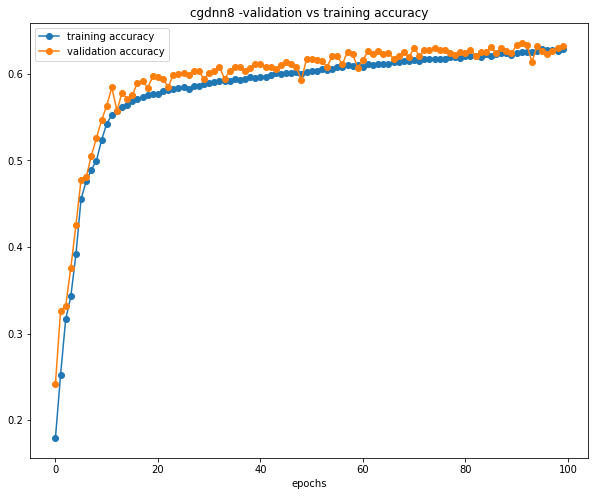

None

32/32 [==============================] - 1s 22ms/step


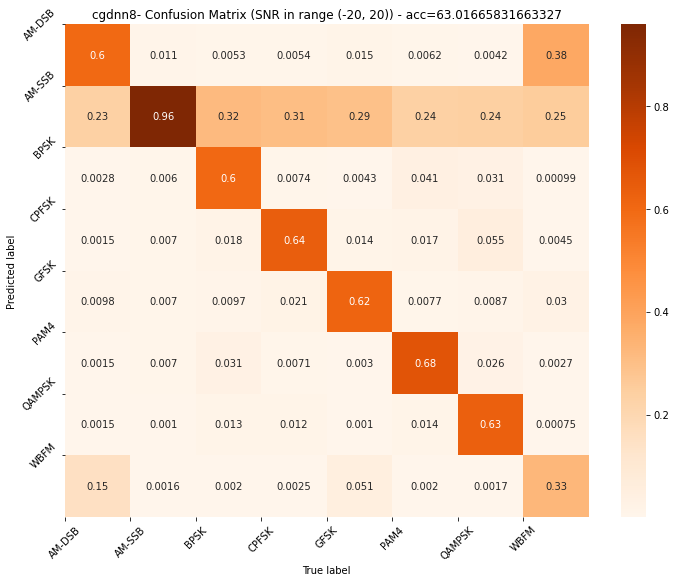

13/13 [==============================] - 0s 20ms/step


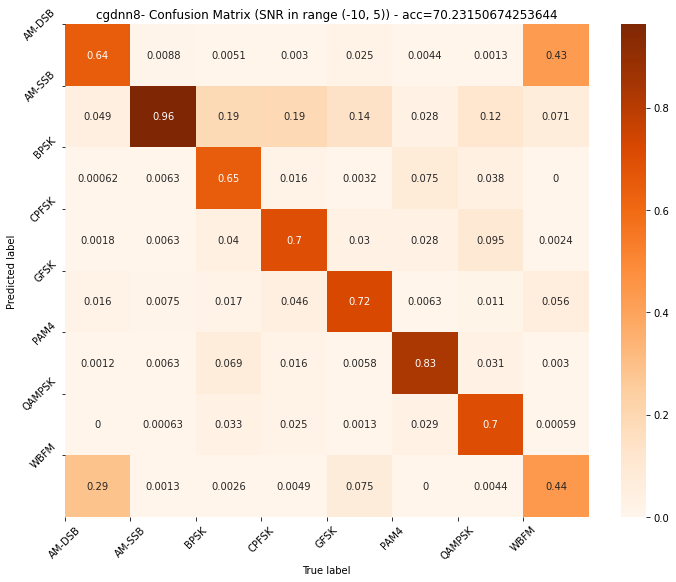

11/11 [==============================] - 0s 21ms/step


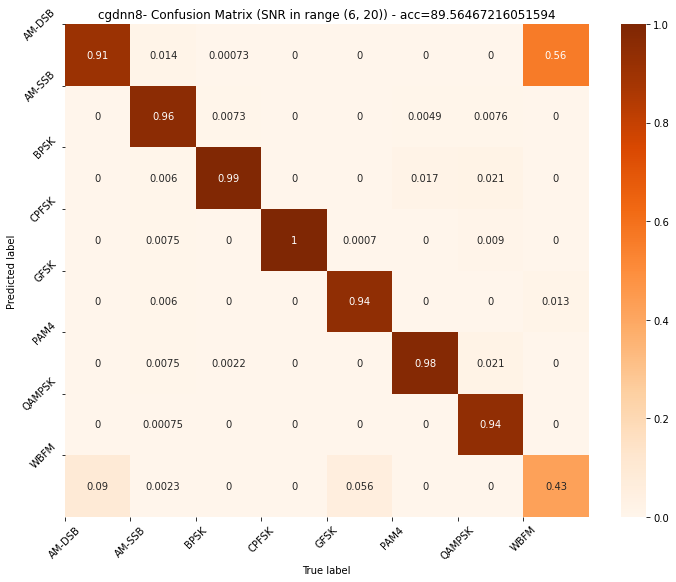

2/2 [==============================] - 0s 26ms/step


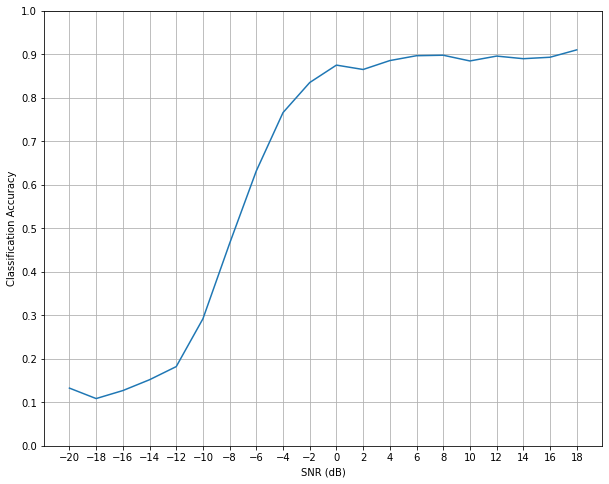

In [ ]:
#Need to reshape I/Q data from 3D into 4D to input into model
nclass = 8
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

cgdnn_model = build_cgdnn_net1(X_test.shape[1], X_test.shape[2])
cgdnn_model_evaluater = ModelEvaluater(cgdnn_model, X_train2, y_train,X_val2, y_val, X_test2, y_test, labels_test, BATCH_SIZE, 'cgdnn8' )
cgdnn_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cgdnn_model_evaluater.print_summary()

In [ ]:
import joblib
data = joblib.load(root_path + 'double CGDNN 33/data/rml_trainvaltest3.hdf5')

In [ ]:
def build_cgdnn_net2(X1, X2):
  dr = 0.5  # dropout rate l

  # Reshape [N,2,128] to [N,1,2,128] on input
  input_x = Input(shape=(1, X1, X2))

  # channels_first corresponds to inputs with shape (batch, channels, height, width).
  # Build our model
  # 1*8--1*8--1*8
  #input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(input_x)

  layer1 = Conv2D(50, (1, 8), padding='same', activation="relu", name="conv1", kernel_initializer='glorot_uniform', data_format="channels_first")(input_x)
  #layer1 = Dropout(dr)(layer1)
  layer1 = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)

  #layer10 = Convolution2D(50, (1, 8), padding="valid", activation="relu", name="conv1011", kernel_initializer='glorot_uniform', data_format="channels_first")(layer1)
  #layer10 = Dropout(dr)(layer10)

  layer2 = Convolution2D(50, (1, 8), padding="valid", activation="relu", name="conv201", kernel_initializer='glorot_uniform', data_format="channels_first")(layer1)
  layer2 = Dropout(dr)(layer2)
  layer2 = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

  #layer20 = Convolution2D(50, (1, 8), padding='valid', activation="relu", name="conv2011", kernel_initializer='glorot_uniform', data_format="channels_first")(layer2)
  #layer20 = Dropout(dr)(layer20)

  layer3 = Convolution2D(50, (1, 8), padding='valid', activation="relu", name="conv301", kernel_initializer='glorot_uniform', data_format="channels_first")(layer2)
  #layer3 = Dropout(dr)(layer3)


  # 第一层和第三层连接
  concat = keras.layers.concatenate([layer1, layer3])

  concat = eca(concat)

  concat_size = list(np.shape(concat))
  input_dim = int(concat_size[-1] * concat_size[-2])
  timesteps = int(concat_size[-3])
  concat = Reshape((timesteps, input_dim))(concat)
  gru_out = GRU(50, activation='tanh', input_dim=input_dim, input_length=timesteps)(concat)
  layer_dense1 = Dense(256, activation='tanh', kernel_initializer='he_normal', name="dense1")(gru_out)
  layer_dropout = Dropout(dr)(layer_dense1)
  layer_dense2 = Dense(NUM_CLASSES, kernel_initializer='he_normal', name="dense2")(layer_dropout)
  layer_softmax = Activation('softmax')(layer_dense2)

  output = Reshape([NUM_CLASSES])(layer_softmax)
  model = Model(inputs=input_x, outputs=output)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
#load data
X_train = data['train']['X']
labels_train = data['train']['labels'] 

X_val = data['val']['X']
labels_val = data['val']['labels'] 

X_test = data['test']['X']
labels_test = data['test']['labels'] 

In [ ]:
#Extract QAMs and PSKs only
y = labels_train[:,0]
idx = np.where((y == '8PSK') | (y == 'QAM16') | (y == 'QAM64') | (y == 'QPSK'))
y_train = y[idx]
X_train = X_train[idx]

y = labels_val[:,0]
idx = np.where((y == '8PSK') | (y == 'QAM16') | (y == 'QAM64') | (y == 'QPSK'))
y_val = y[idx]
X_val = X_val[idx]

y = labels_test[:,0]
idx = np.where((y == '8PSK') | (y == 'QAM16') | (y == 'QAM64') | (y == 'QPSK'))
y_test = y[idx]
X_test = X_test[idx]
labels_test = labels_test[idx]

In [ ]:
#convert to ampphase
X_ap_train = arr_iq2ap(X_train)
X_ap_val = arr_iq2ap(X_val)
X_ap_test = arr_iq2ap(X_test)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 50, 2, 128)   450         ['input_9[0][0]']                
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 50, 2, 132)  0           ['conv1[0][0]']                  
 2D)                                                                                              
                                                                                                  
 conv201 (Conv2D)               (None, 50, 2, 125)   20050       ['zero_padding2d_18[0][0]']

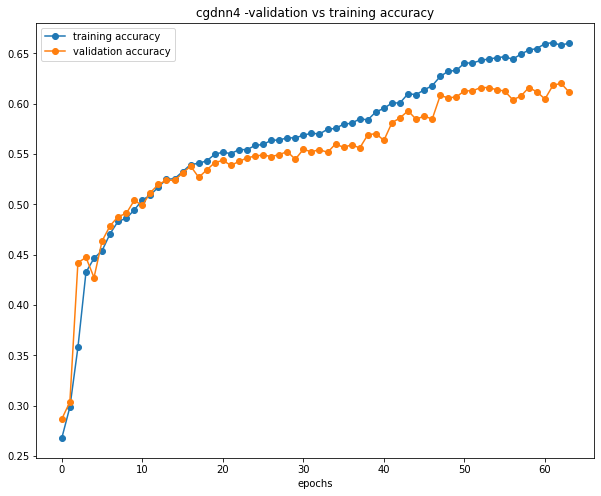

None

16/16 [==============================] - 1s 21ms/step


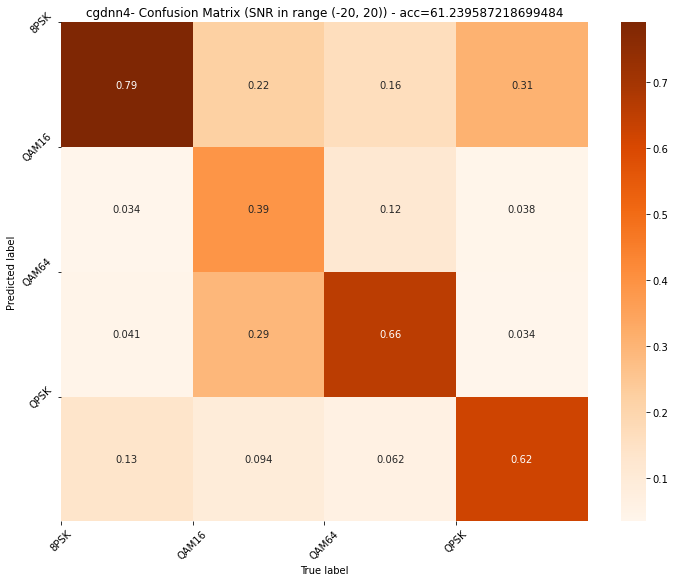

7/7 [==============================] - 0s 18ms/step


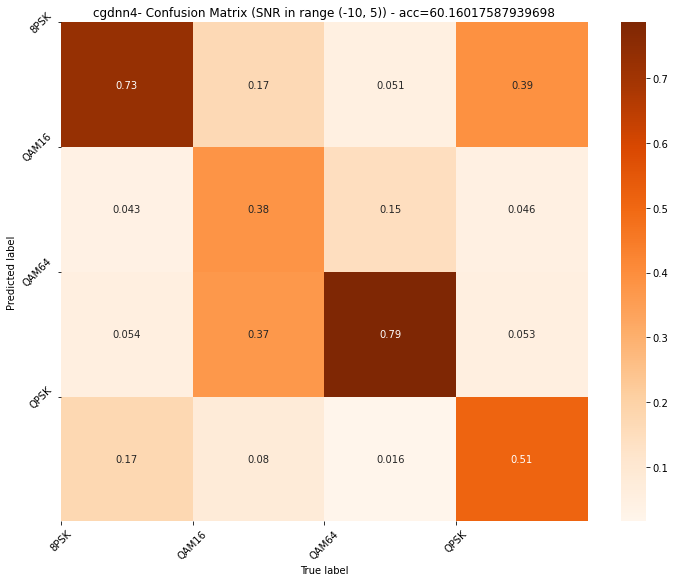

6/6 [==============================] - 0s 18ms/step


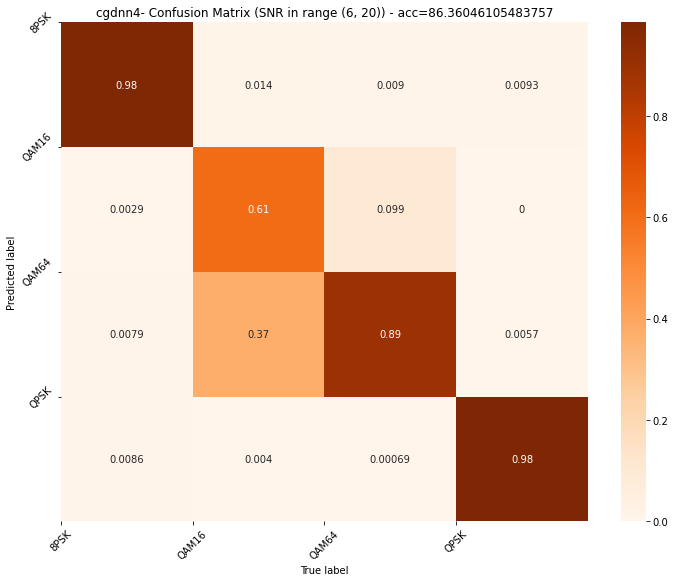

1/1 [==============================] - 0s 24ms/step


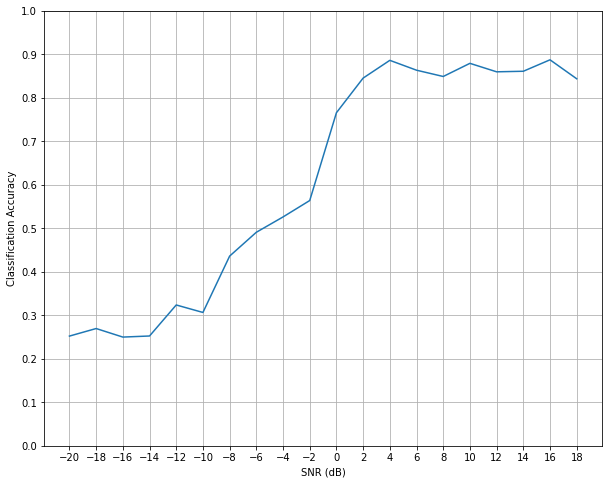

In [ ]:
NUM_CLASSES = 4
#Need to reshape I/Q data from 3D into 4D to input into model
X_ap_train2 = X_ap_train.reshape(X_ap_train.shape[0], 1, X_ap_train.shape[1], X_ap_train.shape[2])
X_ap_val2 = X_ap_val.reshape(X_ap_val.shape[0], 1, X_ap_val.shape[1], X_ap_val.shape[2])
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])

cgdnn_ap_model = build_cgdnn_net2(X_ap_test.shape[1], X_ap_test.shape[2])
cgdnn_ap_model_evaluater = ModelEvaluater(cgdnn_ap_model, X_ap_train2, y_train, X_ap_val2, y_val, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'cgdnn4' )
cgdnn_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cgdnn_ap_model_evaluater.print_summary()

In [ ]:
#After a bit of guessing and validation
#Probs can use onehot also...
cnn1_classdict = {}
cnn1_classdict[0] = 'AM-DSB'
cnn1_classdict[1] = 'AM-SSB'
cnn1_classdict[2] = 'BPSK'
cnn1_classdict[3] = 'CPFSK'
cnn1_classdict[4] = 'GFSK'
cnn1_classdict[5] = 'PAM4'
cnn1_classdict[6] = 'QAMPSK'
cnn1_classdict[7] = 'WBFM'

cnn2_classdict = {}
cnn2_classdict[0] = '8PSK'
cnn2_classdict[1] = 'QAM16'
cnn2_classdict[2] = 'QAM64'
cnn2_classdict[3] = 'QPSK'


mod_to_idx = {}
mod_to_idx['8PSK'] = 0
mod_to_idx['AM-DSB'] = 1
mod_to_idx['AM-SSB'] = 2
mod_to_idx['BPSK'] = 3
mod_to_idx['CPFSK'] = 4
mod_to_idx['GFSK'] = 5
mod_to_idx['PAM4'] = 6
mod_to_idx['QAM16'] = 7
mod_to_idx['QAM64'] = 8
mod_to_idx['QPSK'] = 9
mod_to_idx['WBFM'] = 10


In [ ]:
#combine predictions from cnn1 and cnn2
def combined_predict(X_test):
  #cnn1
  nclass = 8
  X_iq = X_test.reshape([X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]])
  cnn_1 = build_cgdnn_net1(X_iq.shape[2], X_iq.shape[3])
  cnn_1.load_weights(root_path + 'double CGDNN 33/cgdnn8-weights-92.hdf5')

  #nclass = 7
  #cnn_1 = build_cnn_net(X_test.shape[1], X_test.shape[2])
  #cnn_1.load_weights(root_path + 'model evaluation/CNN-Net7-weights-35.hdf5')

  out_prob = cnn_1.predict(X_iq)
  out_pred = np.argmax(out_prob,axis=1) # 打印最大概率对应的标签
  #out_pred = np.mean(out_prob,axis=1)
  out_pred = np.array([cnn1_classdict[i] for i in out_pred])

  idx = np.where(out_pred == 'QAMPSK') #寻找QAMPSK的坐标
  X_QAMPSK = X_test[idx]
  X_ap = arr_iq2ap(X_QAMPSK)

  #cnn2
  ##NUM_CLASSES = 5原先
  NUM_CLASSES = 4
  X_ap = X_ap.reshape(X_ap.shape[0], 1, X_ap.shape[1], X_ap.shape[2])

  cnn_2 = build_cgdnn_net2(X_ap.shape[2], X_ap.shape[3])#2  3
  cnn_2.load_weights(root_path + 'double CGDNN 33/cgdnn4-weights-54.hdf5')
  out_prob2 = cnn_2.predict(X_ap)
  out_pred2 = np.argmax(out_prob2,axis=1)
  out_pred2 = np.array([cnn2_classdict[i] for i in out_pred2])

  j = 0
  for i, out in enumerate(out_pred):
    if out=='QAMPSK':
      out_pred[i] = out_pred2[j]
      j = j+1
  
  return out_pred


#plot conf mat given predicted and true arrays
def createnplot_confmat(out_pred, y_true):
  confusion_mat = np.zeros([11,11])
  #acc = np.mean(out_pred == y_true) #取平均
  acc = np.argmax(out_pred == y_true)
  # fill in the confusion matrix
  for i in range(y_true.shape[0]):
      true_idx = mod_to_idx[y_true[i]]
      pred_idx = mod_to_idx[out_pred[i]]          
      confusion_mat[pred_idx,true_idx] += 1

  # normalize the matrix column wise
  for i in range(11):
      if np.sum(confusion_mat[:,i]) > 0:
        confusion_mat[:,i] /= np.sum(confusion_mat[:,i])

  plot_confusion_matrix(confusion_mat, title=str(acc), labels = np.unique(labels_test[:,0]))


#return accuracies across snr range
def snr_accs(out_pred, labels_true):
  snr_accs = {}
  labels_snrs = np.array([int(snr) for snr in labels_true[:,1]])
  snrs_uniq = np.unique(labels_snrs)

  for snr in sorted(snrs_uniq):
    idx = np.where(labels_snrs == snr)
    y_pred = out_pred[idx]
    y_true = labels_true[idx][:,0]
    acc = np.mean(y_pred == y_true)
    snr_accs[snr] = acc
  return snr_accs

In [ ]:
import joblib
data = joblib.load(root_path + 'double CGDNN 33/data/rml_trainvaltest3.hdf5')

In [ ]:
#load data
X_train = data['train']['X']
labels_train = data['train']['labels'] 
y_train = labels_train[:,0]

X_val = data['val']['X']
labels_val = data['val']['labels'] 
y_val = labels_val[:,0]

X_test = data['test']['X']
labels_test = data['test']['labels'] 
y_test = labels_test[:,0]

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 conv101 (Conv2D)               (None, 50, 2, 121)   450         ['input_19[0][0]']               
                                                                                                  
 dropout_60 (Dropout)           (None, 50, 2, 121)   0           ['conv101[0][0]']                
                                                                                                  
 zero_padding2d_38 (ZeroPadding  (None, 50, 2, 125)  0           ['dropout_60[0][0]']             
 2D)                                                                                       

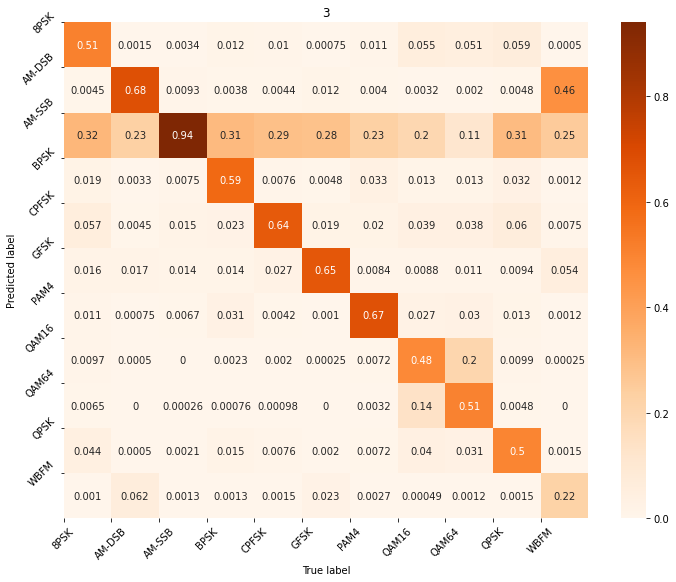

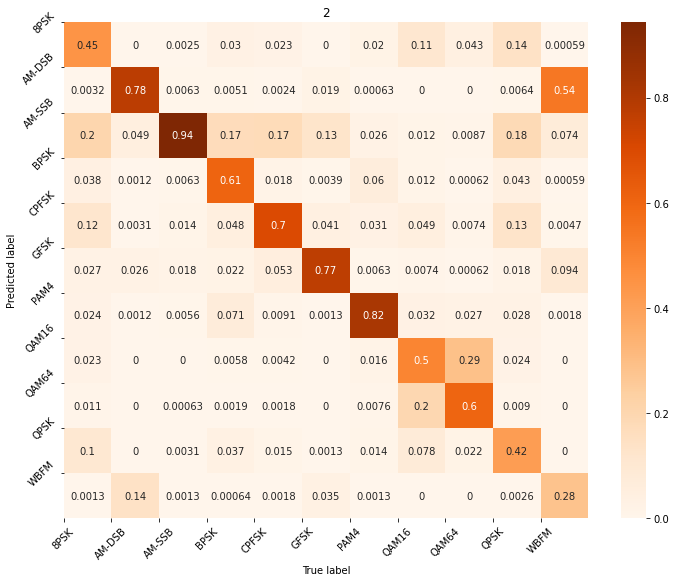

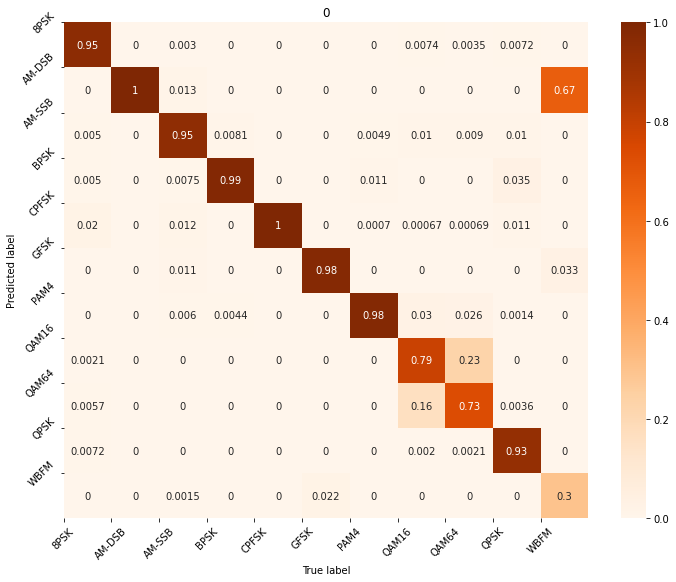

In [ ]:
#plot confusion matrices at different snr
#NUM_CLASSES = 4#原先
NUM_CLASSES = 4
out_pred = combined_predict(X_test)

snr_ranges = [(-20, 20), (-10, 5), (6, 20)]
for i, snr_rng in enumerate(snr_ranges):
   snrs = np.array([int(lbl) for lbl in labels_test[:,1]])
   idx = np.where((snrs >= snr_rng[0]) & (snrs <=snr_rng[1]))

   y_pred_snr = out_pred[idx]
   y_snr = labels_test[idx][:,0]
   plt.subplot(1,3,i+1)
   createnplot_confmat(y_pred_snr, y_snr)
   plt.show()

In [ ]:
#combined predict
#NUM_CLASSES = 4#原先
NUM_CLASSES = 4
out_combined = combined_predict(X_test)
combined_accpersnr = snr_accs(out_combined, labels_test)

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 conv101 (Conv2D)               (None, 50, 2, 121)   450         ['input_21[0][0]']               
                                                                                                  
 dropout_66 (Dropout)           (None, 50, 2, 121)   0           ['conv101[0][0]']                
                                                                                                  
 zero_padding2d_42 (ZeroPadding  (None, 50, 2, 125)  0           ['dropout_66[0][0]']             
 2D)                                                                                       

In [ ]:
def build_cldnn_net(X1, X2):
  dr = 0.5  # dropout rate l

  # Reshape [N,2,128] to [N,1,2,128] on input
  input_x = Input(shape=(1, X1, X2))

  # channels_first corresponds to inputs with shape (batch, channels, height, width).
  # Build our model
  input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(input_x)

  layer1 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform', data_format="channels_first")(input_x_padding)
  layer1 = Dropout(dr)(layer1)
  layer1_padding = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)

  layer2 = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform', data_format="channels_first")(layer1_padding)
  layer2 = Dropout(dr)(layer2)
  layer2 = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

  layer3 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv3", kernel_initializer='glorot_uniform', data_format="channels_first")(layer2)
  layer3 = Dropout(dr)(layer3)

  concat = keras.layers.concatenate([layer1, layer3])
  
  concat_size = list(np.shape(concat))
  input_dim = int(concat_size[-1] * concat_size[-2])
  timesteps = int(concat_size[-3])
  concat = Reshape((timesteps, input_dim))(concat)
  lstm_out = LSTM(50, input_dim=input_dim, input_length=timesteps)(concat)
  layer_dense1 = Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1")(lstm_out)
  layer_dropout = Dropout(dr)(layer_dense1)
  layer_dense2 = Dense(NUM_CLASSES, kernel_initializer='he_normal', name="dense2")(layer_dropout)
  layer_softmax = Activation('softmax')(layer_dense2)

  output = Reshape([NUM_CLASSES])(layer_softmax)
  model = Model(inputs=input_x, outputs=output)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
#NUM_CLASSES = 8原先
NUM_CLASSES = 11
#CLDNN trained on low, med, high SNRs
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
cldnn_model = build_cldnn_net(X_test.shape[1], X_test.shape[2])
cldnn_model.load_weights(root_path + 'all class 33/CLDNN_IQ-weights-47.hdf5')
cldnn_model_evaluater = ModelEvaluater(cldnn_model, X_test2, y_test,X_test2, y_test, X_test2, y_test, labels_test, BATCH_SIZE, 'CLDNN_IQ' )
cldnn_accpersnr = cldnn_model_evaluater.accpersnr_model()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, 1, 2, 132)   0           ['input_7[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, 50, 2, 125)   450         ['zero_padding2d_12[0][0]']      
                                                                                                  
 dropout_21 (Dropout)           (None, 50, 2, 125)   0           ['conv1[0][0]']            

In [ ]:
#convert to ampphase
X_ap_train = arr_iq2ap(X_train)
X_ap_val = arr_iq2ap(X_val)
X_ap_test = arr_iq2ap(X_test)

In [ ]:
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model = build_cldnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model.load_weights(root_path + 'all class 33/CLDNN_AP-weights-38.hdf5')
cldnn_ap_model_evaluater = ModelEvaluater(cldnn_ap_model, X_ap_test2, y_test, X_ap_test2, y_test, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'CLDNN_AP' )
cldnn_ap_accpersnr = cldnn_ap_model_evaluater.accpersnr_model()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1, 2, 128)]  0           []                               
                                                                                                  
 zero_padding2d_15 (ZeroPadding  (None, 1, 2, 132)   0           ['input_8[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, 50, 2, 125)   450         ['zero_padding2d_15[0][0]']      
                                                                                                  
 dropout_25 (Dropout)           (None, 50, 2, 125)   0           ['conv1[0][0]']            

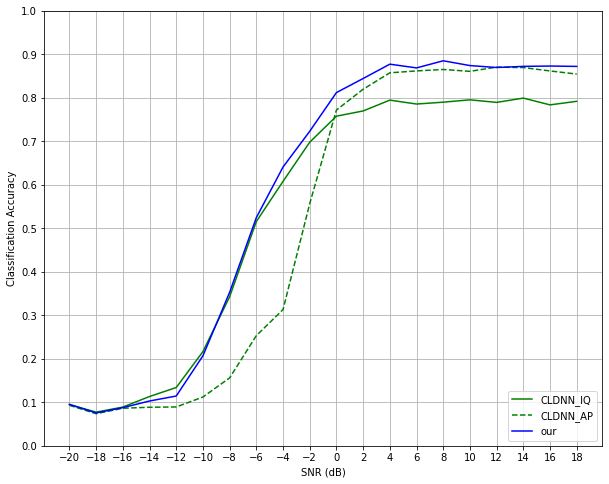

In [ ]:
# plot acc-vs-snr graphs for different models
cldnn_iq, = plt.plot(list(cldnn_accpersnr.keys()),list(cldnn_accpersnr.values()), 'g-', label='CLDNN_IQ')
cldnn_ap, = plt.plot(list(cldnn_ap_accpersnr.keys()),list(cldnn_ap_accpersnr.values()), 'g--', label='CLDNN_AP')
combined, = plt.plot(list(combined_accpersnr.keys()),list(combined_accpersnr.values()), 'b-', label='our')

plt.xlabel("SNR (dB)")
plt.ylabel("Classification Accuracy")
plt.xticks(list(combined_accpersnr.keys()))
plt.legend(handles = [cldnn_iq, cldnn_ap, combined])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.legend(loc="lower right")
plt.grid(True)
plt.show()